## Supervised uMAP Study B

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from scipy.interpolate import splprep, splev
import umap, os

In [3]:
#Configuration
RANDOM_STATE = 42
WEAK_TIME_WEIGHT = 0.05
TARGET_WEIGHT = 0.18
import random
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Read Data

In [4]:
wcct = pd.read_csv("WCCT_normalized_BL2.csv")
vxa  = pd.read_csv("VXA_normalized_BL2.csv")
mcl  = pd.read_excel("matched_populations.xlsx")

### Match cell populations

In [5]:
mcl["WCCT"] = mcl["WCCT"].astype(str).str.strip()
mcl["VXA"]  = mcl["VXA"].astype(str).str.strip()
wcct_cols = mcl["WCCT"].dropna().unique().tolist()
vxa_cols  = mcl["VXA"].dropna().unique().tolist()

In [6]:
wcct = wcct[[c for c in wcct.columns if c in wcct_cols or c in ["VOLUNTEER","DPC","SHEDDER"]]]
vxa  = vxa[[c for c in vxa.columns if c in vxa_cols or c in ["VOLUNTEER","DPC","SHEDDER"]]]
vxa.columns = wcct.columns

### Filter shedders and valid days

In [7]:
wcct = wcct[(wcct["SHEDDER"]==1) & (wcct["DPC"].isin([1,2,3,4,5,6,7]))]
vxa  = vxa[(vxa["SHEDDER"]==1) & (vxa["DPC"].isin([1,2,3,5,7]))]

In [8]:
pop_cols = [c for c in wcct.columns if c not in ["VOLUNTEER","DPC","SHEDDER"]]

### Detrend per volunteer

In [9]:
def detrend(df, cols):
    df = df.copy()
    for vid, sub in df.groupby("VOLUNTEER"):
        for c in cols:
            mean_val = sub[c].mean()
            df.loc[df["VOLUNTEER"]==vid, c] = sub[c] - mean_val
    return df

In [10]:
wcct = detrend(wcct, pop_cols)
vxa  = detrend(vxa,  pop_cols)

### Train RF on Study A

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(wcct[pop_cols])
y_train = wcct["DPC"]
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Test RF on Study B

In [12]:
if os.path.exists("Validation_Predictions_StudyB.csv"):
    val_df = pd.read_csv("Validation_Predictions_StudyB.csv")
    val_df["predicted"] = (
        val_df["predicted"]
        .astype(str)
        .str.replace("[","",regex=False)
        .str.replace("]","",regex=False)
        .astype(float)
    )
    val_summary = (
        val_df.groupby(["ID","iteration"])["predicted"]
        .mean()
        .reset_index()
    )
    val_summary.rename(columns={"iteration":"DAY","predicted":"Predicted_DAY_raw"}, inplace=True)
    vxa = pd.merge(vxa, val_summary, how="left", left_on=["VOLUNTEER","DPC"], right_on=["ID","DPC"])
    vxa.drop(columns=["ID"], inplace=True)
else:
    X_test = scaler.transform(vxa[pop_cols])
    vxa["Predicted_DAY_raw"] = rf.predict(X_test)

In [13]:
def assign_to_nearest_day(value):
    if pd.isna(value): return np.nan
    if value < 2.2: return 1
    elif value < 2.7: return 2
    elif value < 4.0: return 3
    elif value < 6.0: return 5
    else: return 7
vxa["Predicted_DAY"] = vxa["Predicted_DAY_raw"].apply(assign_to_nearest_day)

### Supervised uMAP

In [14]:
X_aug = np.column_stack([X_train, y_train.values.reshape(-1,1) * WEAK_TIME_WEIGHT])
reducer = umap.UMAP(
    n_neighbors=100, min_dist=0.35, metric="correlation",
    target_metric="l2", target_weight=TARGET_WEIGHT,
    random_state=RANDOM_STATE,
    n_jobs=1
)
embedding = reducer.fit_transform(X_aug, y=y_train.values.reshape(-1,1))

In [15]:
X_test = scaler.transform(vxa[pop_cols])
vxa_emb = reducer.transform(X_test)
vxa["uMAP1"], vxa["uMAP2"] = vxa_emb[:,0], vxa_emb[:,1]

In [16]:
vxa["uMAP1"] = (vxa["uMAP1"] - 5) * 1.3 + 5
vxa["uMAP2"] = (vxa["uMAP2"] - 5) * 1.3 + 5

In [17]:
def minmax(a): return (a - a.min()) / (a.max() - a.min()) * 10
vxa["uMAP1"], vxa["uMAP2"] = minmax(vxa["uMAP1"]), minmax(vxa["uMAP2"])

In [18]:
r1, _ = spearmanr(vxa["DPC"], vxa["uMAP1"])
r2, _ = spearmanr(vxa["DPC"], vxa["uMAP2"])

### Import color palettes

In [19]:
palette_df = pd.read_csv("viridis_tealrose_7bins.csv")
palette_df.columns = ["Day", "Actual_Color", "Predicted_Color"]
VALID_DAYS = [1,2,3,5,7]
palette_df = palette_df[palette_df["Day"].isin(VALID_DAYS)]

In [20]:
def color_map_from_csv(series, column):
    color_dict = dict(zip(palette_df["Day"], palette_df[column]))
    return [color_dict.get(int(round(d)), "#BEBEBE") for d in series]

In [21]:
def clean_axes(ax):
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)
        spine.set_color("black")
    ax.set_xlabel("uMAP1", fontsize=12)
    ax.set_ylabel("uMAP2", fontsize=12)

In [22]:
def add_dot_legend(ax, title, palette_df, column):
    handles = [
        Line2D([0],[0], marker='o', linestyle='',
               color=palette_df[column].iloc[i],
               markersize=8, label=str(palette_df["Day"].iloc[i]))
        for i in range(len(palette_df))
    ]
    ax.legend(handles=handles, title=title,
              loc="upper left", bbox_to_anchor=(1.02,1), frameon=True)

### Plot uMAP and trajectory

In [23]:
def plot_umap(df, hue_col, title, color_col):
    fig, ax = plt.subplots(figsize=(9,8))
    point_colors = color_map_from_csv(df[hue_col], color_col)
    ax.scatter(df["uMAP1"], df["uMAP2"], c=point_colors,
               s=85, linewidths=0.5,edgecolors="none", zorder=1)
    cent = df.groupby(hue_col)[["uMAP1","uMAP2"]].mean().sort_index().reset_index()
    if len(cent) >= 4:
        tck, u = splprep([cent["uMAP1"], cent["uMAP2"]], s=0.5, k=3)
        u_fine = np.linspace(0,1,300)
        x_smooth, y_smooth = splev(u_fine, tck)
        ax.plot(x_smooth, y_smooth, color="#808080", lw=3, alpha=0.9, zorder=2)
    else:
        ax.plot(cent["uMAP1"], cent["uMAP2"],
                color="#808080", lw=3, alpha=0.9, zorder=2)
    for d,(x,y) in cent.set_index(hue_col)[["uMAP1","uMAP2"]].iterrows():
        ax.text(x, y + 0.18, f"{int(d)}",
                ha="center", va="bottom",
                fontsize=13, weight="bold",
                color="black", zorder=3)
    ax.set_title(title, fontsize=14)
    clean_axes(ax)
    add_dot_legend(ax, "Day post challenge", palette_df, color_col)
    plt.tight_layout()
    plt.show()

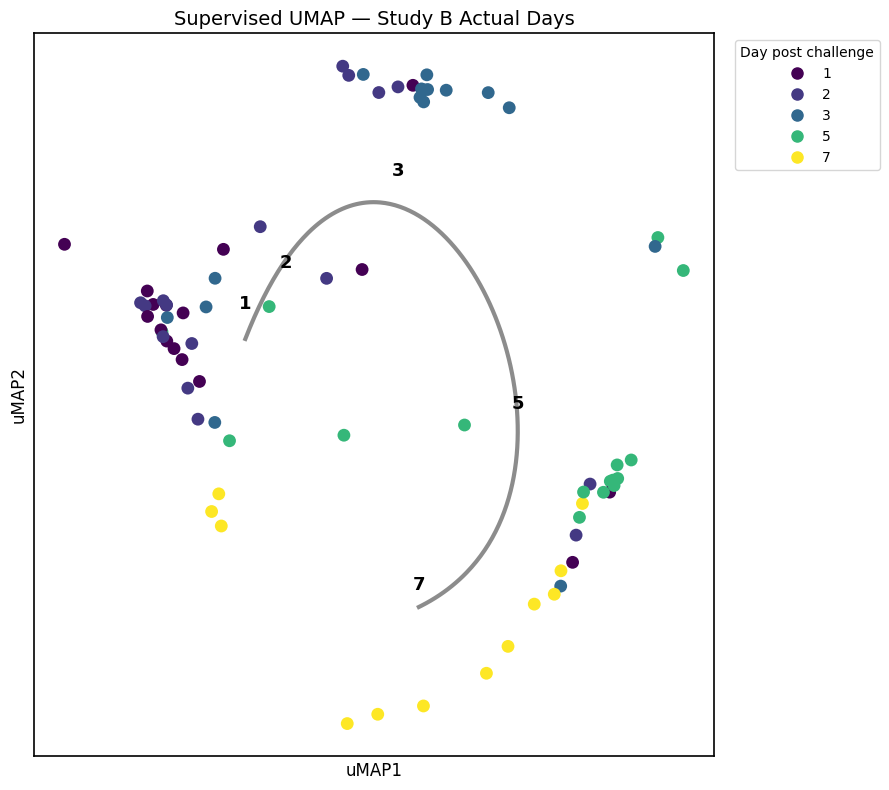

In [24]:
plot_umap(vxa, "DPC","Supervised UMAP — Study B Actual Days","Actual_Color")

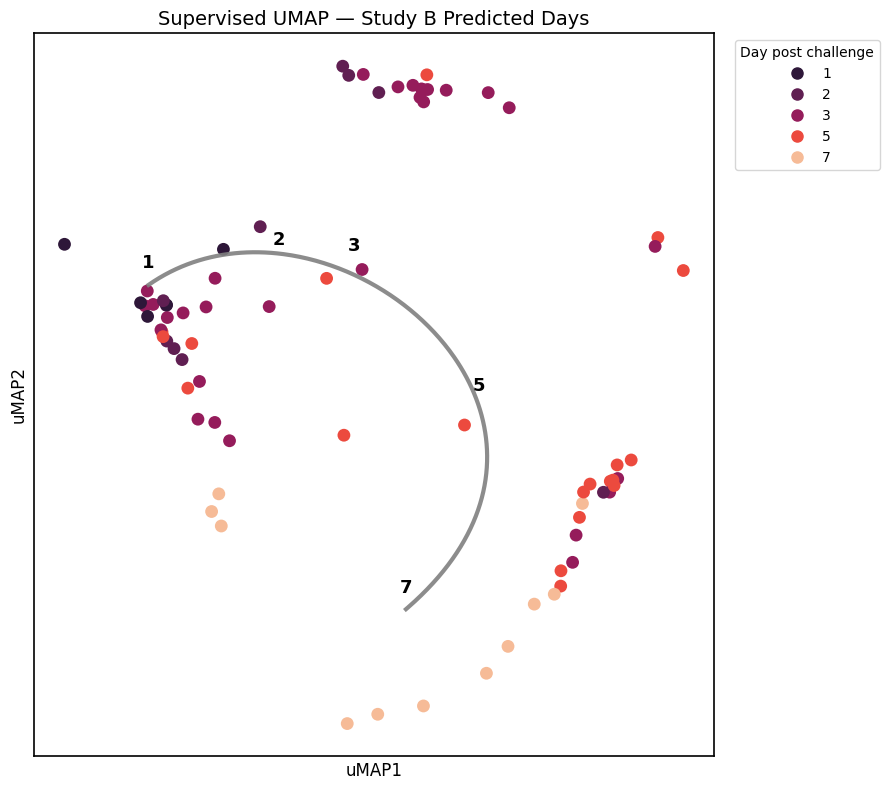

In [25]:
plot_umap(vxa, "Predicted_DAY","Supervised UMAP — Study B Predicted Days","Predicted_Color")